In [34]:
import pandas as pd
import os
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np

from sqlalchemy import create_engine, Text, String, Float
from sqlalchemy.sql import text
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
from plotly.subplots import make_subplots
from scipy.stats import pearsonr

load_dotenv()

CONFIG ={
    "git_token":os.getenv("GIT_TOKEN"),
    "kipris_key":os.getenv("KIPRIS_KEY"),
    "rds_user":os.getenv("DB_USER"),
    "rds_pwd":os.getenv("DB_PASSWORD"),
    "rds_host":os.getenv("DB_HOST"),
    "rds_db":os.getenv("DB_NAME"),
    "rds_port":os.getenv("DB_PORT")
}

git_token = CONFIG["git_token"]
kipris_key = CONFIG["kipris_key"]
rds_user = CONFIG["rds_user"]
rds_pwd = CONFIG["rds_pwd"]
rds_host = CONFIG["rds_host"]
rds_db = CONFIG["rds_db"]
rds_port = CONFIG["rds_port"]

In [35]:
def normalization_text(text):
    text = re.sub(r"http\S+", "", text)  # URL 제거
    text = re.sub(r"[^가-힣a-zA-Z0-9\s]", " ", text)  # 특수문자 제거
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

In [36]:
def batched_encode(texts, model, batch_size=100):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, convert_to_tensor=True)
        embeddings.append(emb)
    return torch.cat(embeddings)

In [37]:
engine_url = f"mysql+pymysql://{rds_user}:{rds_pwd}@{rds_host}:{rds_port}/{rds_db}"
engine = create_engine(engine_url)

df_readme = pd.read_sql_table("github_readmes", con=engine)
df_kipris = pd.read_sql_table("kipris_patent", con=engine)
df_repos = pd.read_sql_table("github_repo", con=engine)

merged_df = pd.merge(df_readme, df_kipris, on="keyword", how="inner")

In [38]:
summary = (
    pd.concat([
        df_readme["keyword"].value_counts().rename("readme_count"),
        df_kipris["keyword"].value_counts().rename("patent_count")
    ], axis=1)
    .fillna(0)
    .astype(int)
)
print(summary)

                        readme_count  patent_count
keyword                                           
reinforcement-learning           141           521
robotics                          90           952
slam                              81           767
ros                               81           164
drone                             29           954


In [39]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

keywords = sorted(set(df_readme["keyword"]).intersection(set(df_kipris["keyword"])))
print(f"공통 키워드 {len(keywords)}개 분석 대상:", keywords)

# 4️⃣ 결과 저장용 리스트
results = []

# 5️⃣ 키워드별로 README vs 특허 간 유사도 계산
for kw in keywords:
    read_texts = df_readme[df_readme["keyword"] == kw]["readme"].dropna().tolist()
    patent_texts = df_kipris[df_kipris["keyword"] == kw]["astrtCont"].dropna().tolist()

    if not read_texts or not patent_texts:
        continue

    # 임베딩 계산
    read_emb = model.encode(read_texts, convert_to_tensor=True)
    patent_emb = batched_encode(patent_texts, model, batch_size=100)

    # 코사인 유사도 계산
    sim_matrix = util.cos_sim(read_emb, patent_emb)

    # 평균/최대 유사도 계산
    mean_sim = torch.mean(sim_matrix).item()
    max_sim = torch.max(sim_matrix).item()

    results.append({
        "keyword": kw,
        "num_readme": len(read_texts),
        "num_patent": len(patent_texts),
        "mean_similarity": round(mean_sim, 4),
        "max_similarity": round(max_sim, 4)
    })

# 6️⃣ 결과 DataFrame 변환
sim_df = pd.DataFrame(results).sort_values("mean_similarity", ascending=False)
print(sim_df)

공통 키워드 5개 분석 대상: ['drone', 'reinforcement-learning', 'robotics', 'ros', 'slam']


100%|██████████| 8/8 [02:00<00:00, 15.10s/it]

                  keyword  num_readme  num_patent  mean_similarity  \
0                   drone          29         954           0.3763   
1  reinforcement-learning         141         521           0.3023   
2                robotics          90         952           0.2921   
4                    slam          81         767           0.2618   
3                     ros          81         164           0.2060   

   max_similarity  
0          0.7258  
1          0.7646  
2          0.7622  
4          0.7542  
3          0.6947  


# 유사도 수치 의미
## 0.75 이상 : 의미적으로 매우 유사
## 0.5 ~ 0.75 : 관련은 잇으나 초점이 다름
## 0.3 ~ 0.5 : 주제 연관은 있으나 다른 방향
## 0.3 미만 : 거의 관련 없음

##### mean_similarity : 해당 수치가 높을수록 README 내용과 특허 기술 개념이 전반적으로 유사하다고 생각 할 수 있음
##### max_similarity : 키워드 내에서 가장 가까운 문서쌍의 유사도 (특정 키워드 README <-> 특정 키워드 특허정보)

(1) 키워드별 평균 유사도 분석

예: robot arm 관련 프로젝트는 평균 0.35 → 기술접점 많음

반면 amr 평균 0.21 → 산업계/연구 간 용어 차이 큼

(2) README vs 특허의 기술 영역 차이

README는 소프트웨어/오픈소스 구현 중심

특허는 하드웨어/알고리즘 원리 중심

같은 ‘ROS’라도 오픈소스 패키지 vs 제어장치 특허로 방향 다름

(3) 연구-산업 기술 연결 지도 (Tech Landscape Map)

키워드별로 README–특허 유사도 시각화 (히트맵, 네트워크 그래프 등)

유사도가 높은 README ↔ 특허 쌍은 “산업화 잠재력 높은 기술군”으로 간주 가능

In [40]:
keywords = sorted(set(df_readme["keyword"]).intersection(set(df_kipris["keyword"])))
print(f"공통 키워드 {len(keywords)}개 분석 중: {keywords}")

# 3️⃣ 결과 저장용
summary_results = []

# 4️⃣ 키워드별 반복 분석
for kw in tqdm(keywords, desc="유사 문서쌍 분석 진행 중"):
    df_r = df_readme[df_readme["keyword"] == kw].dropna(subset=["readme"]).reset_index(drop=True)
    df_p = df_kipris[df_kipris["keyword"] == kw].dropna(subset=["astrtCont"]).reset_index(drop=True)

    if len(df_r) == 0 or len(df_p) == 0:
        continue

    # --- 임베딩 계산 ---
    emb_r = model.encode(df_r["readme"].tolist(), convert_to_tensor=True)
    emb_p = model.encode(df_p["astrtCont"].tolist(), convert_to_tensor=True)

    # --- 코사인 유사도 행렬 계산 ---
    cos_sim = util.cos_sim(emb_r, emb_p)

    # --- 상위 5개 문서쌍 추출 ---
    pairs = []
    for i in range(len(df_r)):
        for j in range(len(df_p)):
            pairs.append((i, j, cos_sim[i][j].item()))

    top_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:5]

    for r_idx, p_idx, score in top_pairs:
        readme_text = df_r.loc[r_idx, "readme"][:300].replace("\n", " ")
        patent_text = df_p.loc[p_idx, "astrtCont"][:300].replace("\n", " ")

        # --- 간단 요약 생성 ---
        # summary = (
        #     f"공통점: 두 문서 모두 '{kw}' 관련 기술에 초점을 맞추며, "
        #     f"README는 '{df_r.loc[r_idx, 'full_name']}' 프로젝트에서 구현된 기능(예: 제어, 센서, 경로계획)을 설명하고, "
        #     f"특허 '{df_p.loc[p_idx, 'inventionTitle']}'은 유사한 개념을 하드웨어적/알고리즘적 수준에서 다룹니다. "
        #     f"차이점: README는 오픈소스 구현 중심, 특허는 기술 보호를 위한 상세 원리 중심입니다."
        # )

        summary_results.append({
            "keyword": kw,
            "similarity": round(score, 4),
            "readme_repo": df_r.loc[r_idx, "full_name"],
            "patent_title": df_p.loc[p_idx, "inventionTitle"],
            "readme_excerpt": readme_text,
            "patent_excerpt": patent_text
            # "summary": summary
        })

# 5️⃣ 결과 DataFrame 생성
report_df = pd.DataFrame(summary_results)
report_df.drop_duplicates(subset=["keyword", "readme_repo", "patent_title"], keep="first", inplace=True)
report_df = report_df.sort_values(["keyword", "similarity"], ascending=[True, False])


report_df.to_sql(
    name="similarity",
    con=engine,
    if_exists="replace",   # 기존 데이터 유지하며 추가하려면 append / 덮어쓰려면 replace
    index=False,
    chunksize=100,
    dtype={
        "keyword": String(100),
        "similarity": Float,
        "readme_repo": String(255),
        "patent_title": String(500),
        "readme_excerpt": Text,
        "patent_excerpt": Text
        # "summary": Text
    }
)




공통 키워드 5개 분석 중: ['drone', 'reinforcement-learning', 'robotics', 'ros', 'slam']


유사 문서쌍 분석 진행 중: 100%|██████████| 5/5 [08:24<00:00, 100.84s/it]


25

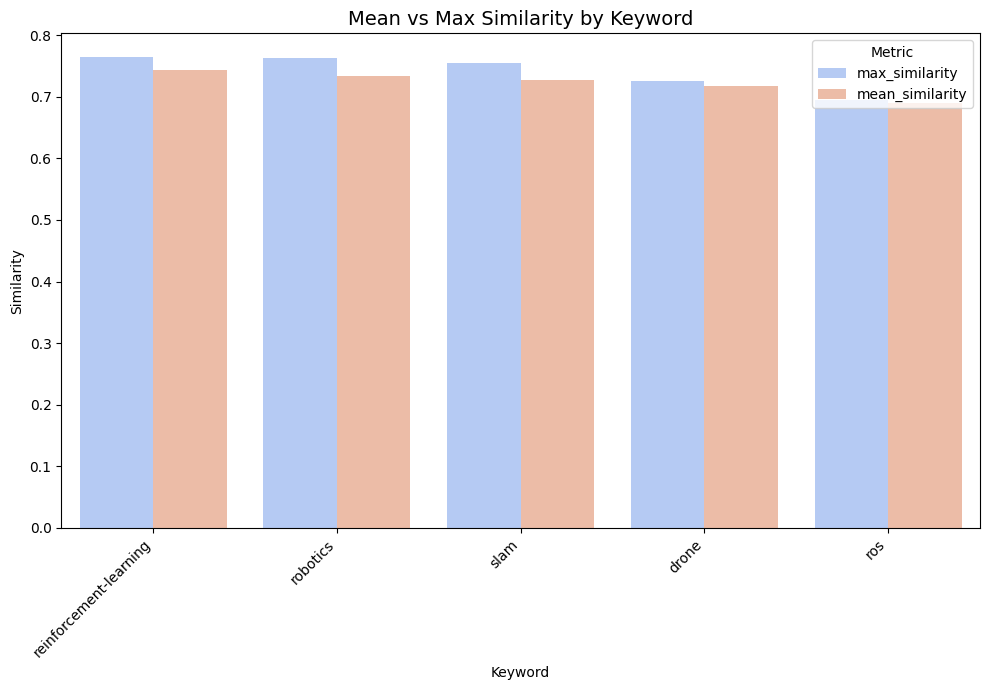

In [41]:
mean_sim = report_df.groupby("keyword")["similarity"].mean().rename("mean_similarity")
max_sim = report_df.groupby("keyword")["similarity"].max().rename("max_similarity")

# 2. Combine into one DataFrame
sim_df = pd.concat([mean_sim, max_sim], axis=1).reset_index()

# 3. Melt for seaborn hue plotting
sim_melted = sim_df.melt(id_vars="keyword", var_name="metric", value_name="similarity")

# 4. Plot with seaborn
plt.figure(figsize=(10, 7))
sns.barplot(
    data=sim_melted.sort_values("similarity", ascending=False),
    x="keyword",
    y="similarity",
    hue="metric",
    palette="coolwarm"
)
plt.title("Mean vs Max Similarity by Keyword", fontsize=14)
plt.xlabel("Keyword")
plt.ylabel("Similarity")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


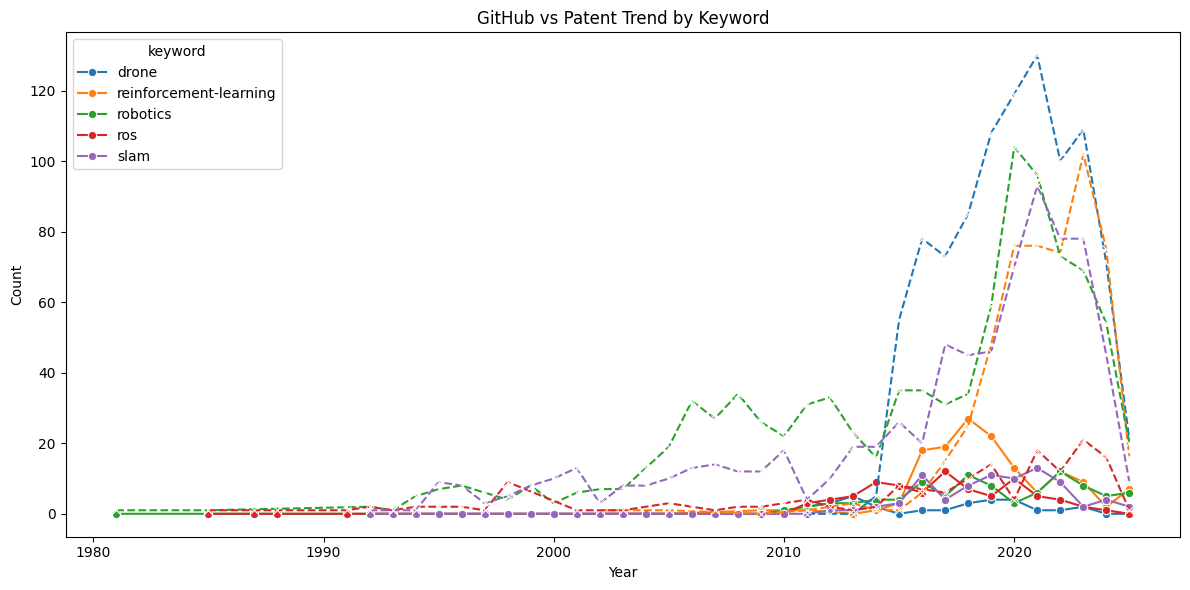

In [42]:
df_readme['year'] = pd.to_datetime(df_repos['created_at']).dt.year
df_kipris['year'] = pd.to_datetime(df_kipris['applicationDate']).dt.year

trend_read = df_readme.groupby(['keyword', 'year']).size().reset_index(name='count_readme')
trend_pat = df_kipris.groupby(['keyword', 'year']).size().reset_index(name='count_patent')

trend = pd.merge(trend_read, trend_pat, on=['keyword', 'year'], how='outer').fillna(0)

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend, x="year", y="count_readme", hue="keyword", marker="o", palette="tab10")
sns.lineplot(data=trend, x="year", y="count_patent", hue="keyword", marker="x", linestyle="--", legend=False)
plt.title("GitHub vs Patent Trend by Keyword")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

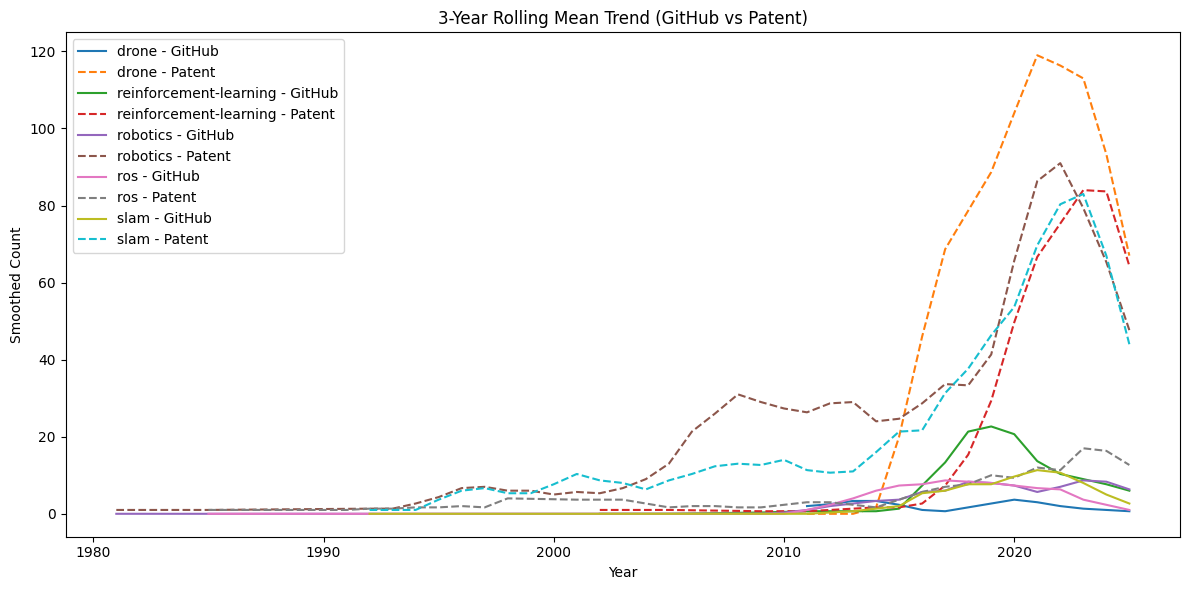

In [43]:
trend_smooth = trend.copy()
trend_smooth["readme_smooth"] = trend_smooth.groupby("keyword")["count_readme"].transform(lambda x: x.rolling(3, min_periods=1).mean())
trend_smooth["patent_smooth"] = trend_smooth.groupby("keyword")["count_patent"].transform(lambda x: x.rolling(3, min_periods=1).mean())

plt.figure(figsize=(12, 6))
for kw in trend_smooth["keyword"].unique():
    subset = trend_smooth[trend_smooth["keyword"] == kw]
    plt.plot(subset["year"], subset["readme_smooth"], label=f"{kw} - GitHub", linestyle="-")
    plt.plot(subset["year"], subset["patent_smooth"], label=f"{kw} - Patent", linestyle="--")
plt.title("3-Year Rolling Mean Trend (GitHub vs Patent)")
plt.xlabel("Year")
plt.ylabel("Smoothed Count")
plt.legend()
plt.tight_layout()
plt.show()

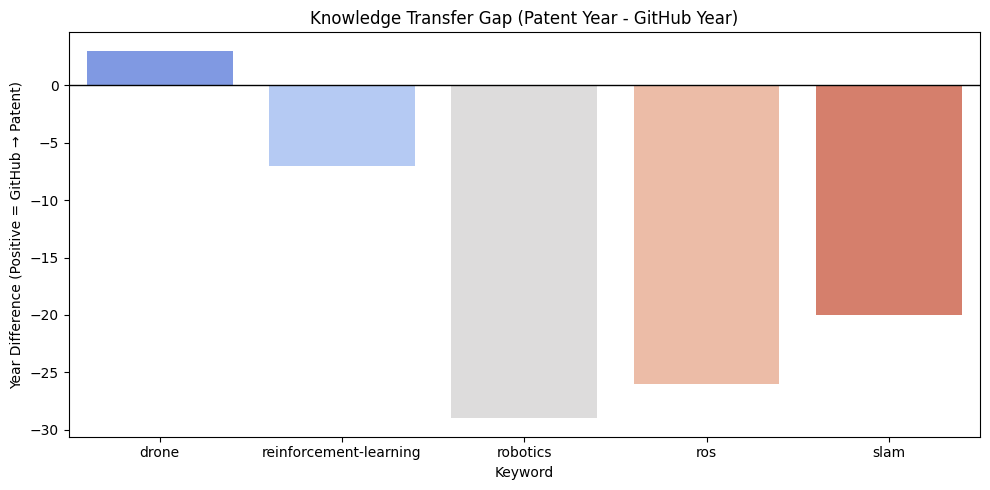

In [44]:
first_git = df_readme.groupby("keyword")["year"].min().rename("first_readme")
first_pat = df_kipris.groupby("keyword")["year"].min().rename("first_patent")

timing = pd.concat([first_git, first_pat], axis=1).dropna()
timing["gap"] = timing["first_patent"] - timing["first_readme"]

plt.figure(figsize=(10, 5))
sns.barplot(data=timing.reset_index(), x="keyword", y="gap", hue="keyword", palette="coolwarm")
plt.axhline(0, color="black", linewidth=1)
plt.title("Knowledge Transfer Gap (Patent Year - GitHub Year)")
plt.xlabel("Keyword")
plt.ylabel("Year Difference (Positive = GitHub → Patent)")
plt.tight_layout()
plt.show()

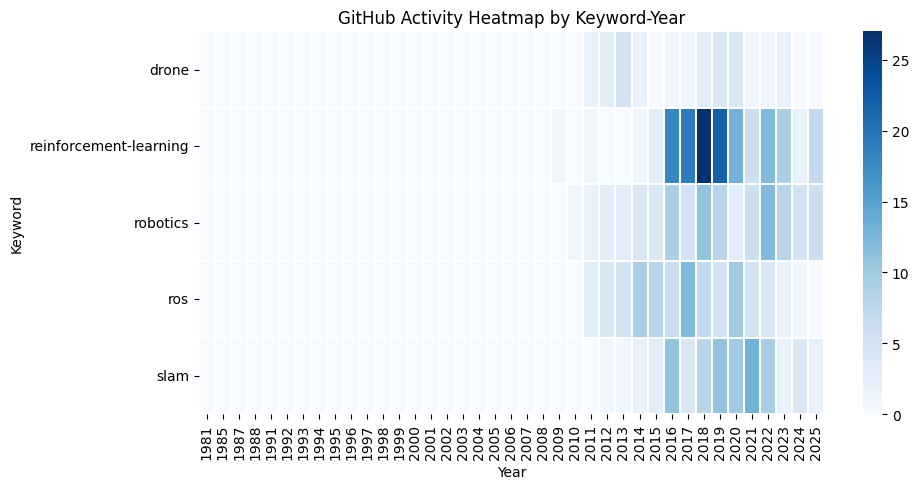

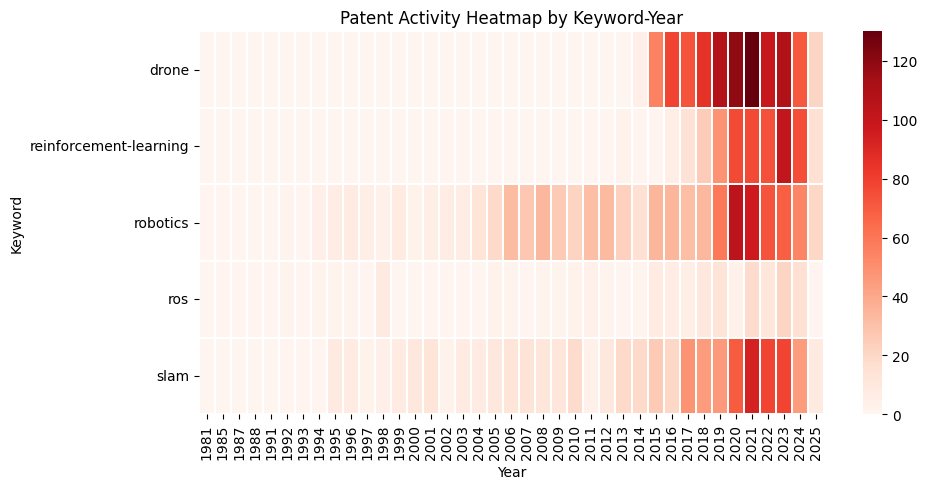

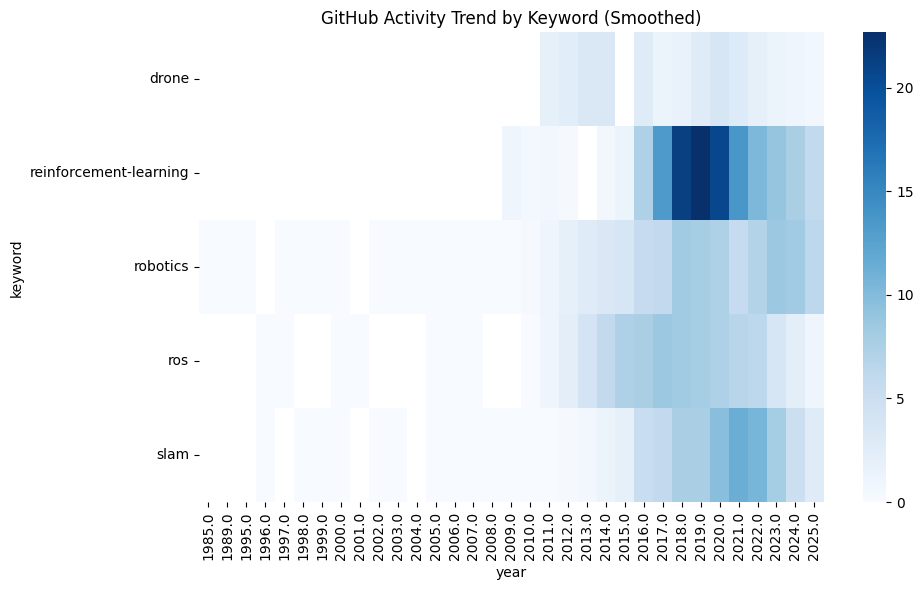

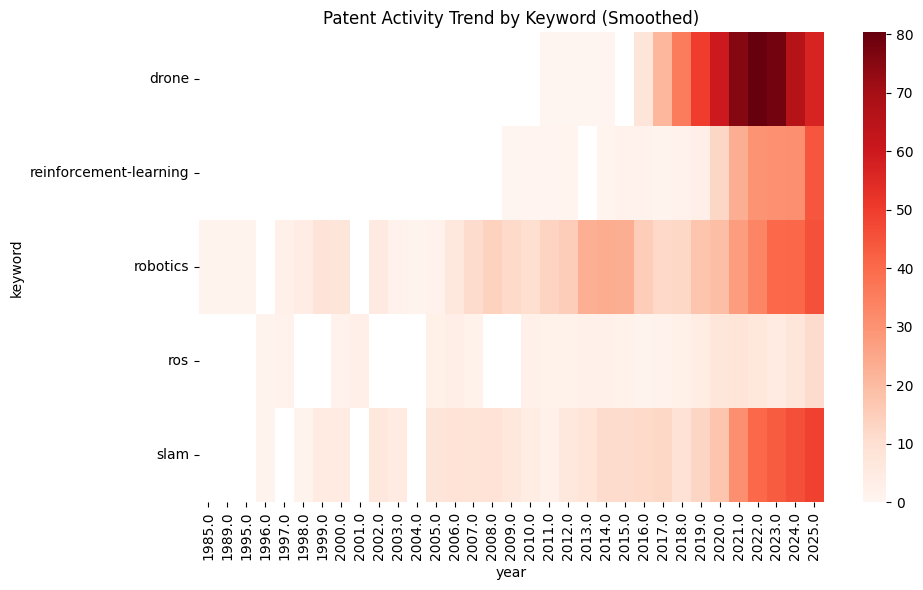

In [45]:
pivot_read = trend.pivot_table(index="keyword", columns="year", values="count_readme", fill_value=0)
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_read, cmap="Blues", linewidths=0.3)
plt.title("GitHub Activity Heatmap by Keyword-Year")
plt.xlabel("Year")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

# Patent Heatmap
pivot_pat = trend.pivot_table(index="keyword", columns="year", values="count_patent", fill_value=0)
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_pat, cmap="Reds", linewidths=0.3)
plt.title("Patent Activity Heatmap by Keyword-Year")
plt.xlabel("Year")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()


# ====================================================================================================================


df_readme = pd.read_sql_table("github_readmes", con=engine)
df_kipris = pd.read_sql_table("kipris_patent", con=engine)
df_repos = pd.read_sql_table("github_repo", con=engine)


# 3️⃣ 연도 컬럼 변환
df_repos["year"] = pd.to_datetime(df_repos["created_at"], errors="coerce").dt.year
df_kipris["year"] = pd.to_datetime(df_kipris["registerDate"], errors="coerce").dt.year

# 4️⃣ GitHub + Readme 결합
df_merged = pd.merge(df_repos, df_readme, on="full_name", how="inner")

# 5️⃣ 키워드 기준으로 GitHub / Patent 집계
repo_yearly = df_merged.groupby(["keyword", "year"]).size().reset_index(name="repo_count")
pat_yearly = df_kipris.groupby(["keyword", "year"]).size().reset_index(name="patent_count")

# 6️⃣ 결합 및 정리
trend_df = pd.merge(repo_yearly, pat_yearly, on=["keyword", "year"], how="outer").fillna(0)

# 7️⃣ Rolling mean (3년 이동평균)
trend_df["repo_smooth"] = trend_df.groupby("keyword")["repo_count"].transform(lambda x: x.rolling(3, min_periods=1).mean())
trend_df["pat_smooth"] = trend_df.groupby("keyword")["patent_count"].transform(lambda x: x.rolling(3, min_periods=1).mean())

# 8️⃣ Heatmap (연도별 트렌드 비교)
pivot = trend_df.pivot(index="keyword", columns="year", values="repo_smooth")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Blues", annot=False)
plt.title("GitHub Activity Trend by Keyword (Smoothed)")
plt.tight_layout()
plt.show()

pivot_pat = trend_df.pivot(index="keyword", columns="year", values="pat_smooth")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_pat, cmap="Reds", annot=False)
plt.title("Patent Activity Trend by Keyword (Smoothed)")
plt.tight_layout()
plt.show()

In [46]:
keywords = ["ROS", "amr", "robot", "robot arm", "robotics"]
num_readme = [77, 6, 128, 1, 52]
num_patent = [166, 811, 952, 14, 952]

# 전이 효율 계산
transfer_efficiency = [p/r if r > 0 else 0 for p, r in zip(num_patent, num_readme)]

# 1️⃣ 산업 전이 강도 기반 Sankey
fig1 = go.Figure(data=[go.Sankey(
    node=dict(
        label=keywords + ["Patent"],
        pad=15,
        thickness=20,
        color="lightgray"
    ),
    link=dict(
        source=list(range(len(keywords))),
        target=[len(keywords)] * len(keywords),
        value=num_patent,
        color="rgba(0,150,200,0.6)"
    )
)])
fig1.update_layout(title_text="GitHub → Patent (by Patent Count)", font_size=12)
fig1.show()

# 2️⃣ 지식 전이 효율 기반 Sankey
fig2 = go.Figure(data=[go.Sankey(
    node=dict(
        label=keywords + ["Patent"],
        pad=15,
        thickness=20,
        color="lightgray"
    ),
    link=dict(
        source=list(range(len(keywords))),
        target=[len(keywords)] * len(keywords),
        value=transfer_efficiency,
        color="rgba(200,100,0,0.6)"
    )
)])
fig2.update_layout(title_text="GitHub → Patent (by Transfer Efficiency: Patent/Readme)", font_size=12)
fig2.show()

In [47]:
patent_year_data = pd.DataFrame({
    "keyword": ["ROS", "ROS", "amr", "amr", "robot", "robotics", "robot arm", "robotics"],
    "year": [2020, 2023, 2021, 2024, 2019, 2022, 2023, 2024],
    "count": [40, 126, 210, 601, 350, 500, 14, 452]
})

# 연도별 노드 생성
keywords = sorted(patent_year_data["keyword"].unique())
years = sorted(patent_year_data["year"].unique())
nodes = keywords + [f"Patent_{y}" for y in years]

# 노드 인덱스 매핑
node_indices = {name: i for i, name in enumerate(nodes)}

# 링크 정보 구성
sources = []
targets = []
values = []

for _, row in patent_year_data.iterrows():
    src = node_indices[row["keyword"]]
    tgt = node_indices[f"Patent_{row['year']}"]
    sources.append(src)
    targets.append(tgt)
    values.append(row["count"])

# Sankey 그래프 생성
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=nodes,
        pad=15,
        thickness=20,
        color="lightgray"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(0,150,200,0.6)"
    )
)])

fig.update_layout(
    title_text="Knowledge Transfer Flow (GitHub → Patent by Year)",
    font_size=12,
    height=600
)
fig.show()

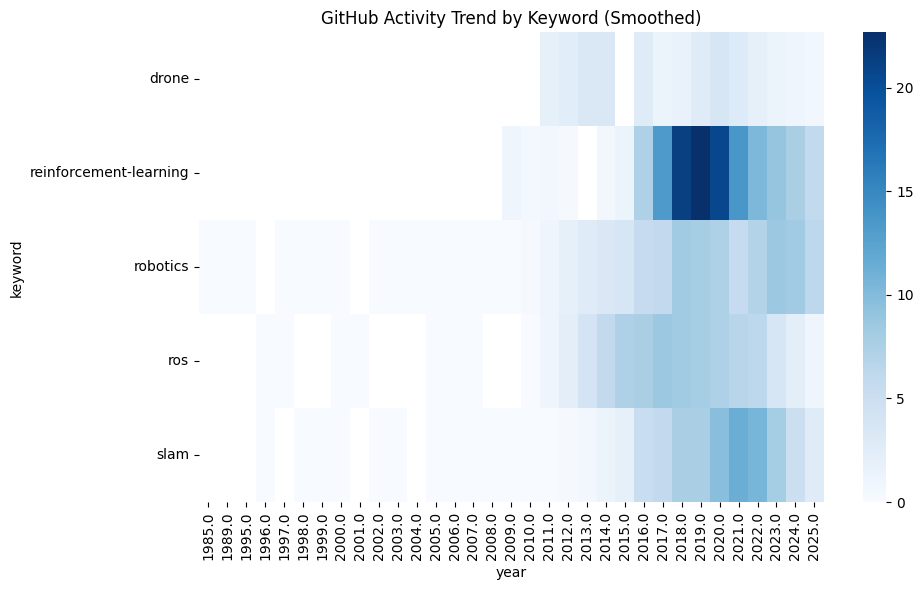

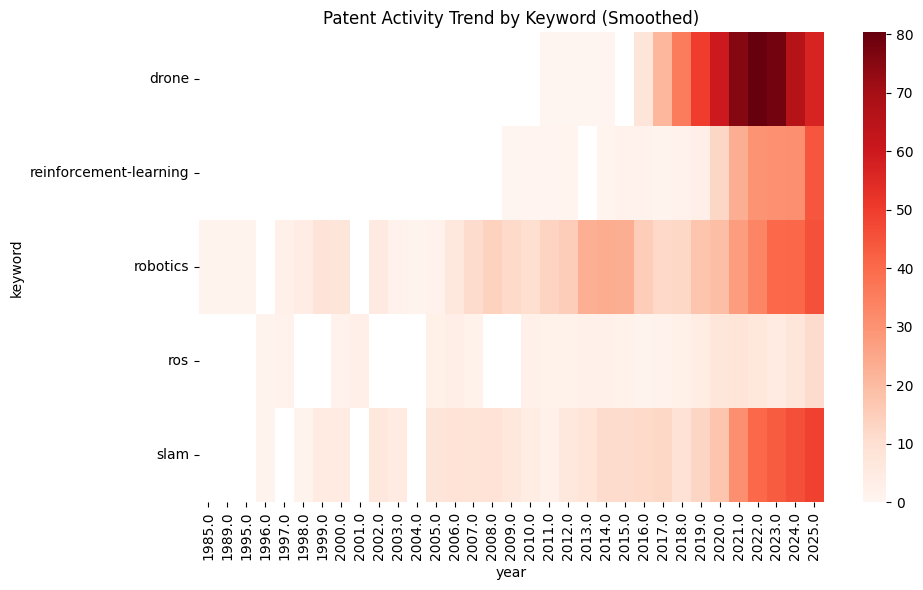

In [48]:
df_readme = pd.read_sql_table("github_readmes", con=engine)
df_kipris = pd.read_sql_table("kipris_patent", con=engine)
df_repos = pd.read_sql_table("github_repo", con=engine)


# 3️⃣ 연도 컬럼 변환
df_repos["year"] = pd.to_datetime(df_repos["created_at"], errors="coerce").dt.year
df_kipris["year"] = pd.to_datetime(df_kipris["registerDate"], errors="coerce").dt.year

# 4️⃣ GitHub + Readme 결합
df_merged = pd.merge(df_repos, df_readme, on="full_name", how="inner")

# 5️⃣ 키워드 기준으로 GitHub / Patent 집계
repo_yearly = df_merged.groupby(["keyword", "year"]).size().reset_index(name="repo_count")
pat_yearly = df_kipris.groupby(["keyword", "year"]).size().reset_index(name="patent_count")

# 6️⃣ 결합 및 정리
trend_df = pd.merge(repo_yearly, pat_yearly, on=["keyword", "year"], how="outer").fillna(0)

# 7️⃣ Rolling mean (3년 이동평균)
trend_df["repo_smooth"] = trend_df.groupby("keyword")["repo_count"].transform(lambda x: x.rolling(3, min_periods=1).mean())
trend_df["pat_smooth"] = trend_df.groupby("keyword")["patent_count"].transform(lambda x: x.rolling(3, min_periods=1).mean())

# 8️⃣ Heatmap (연도별 트렌드 비교)
pivot = trend_df.pivot(index="keyword", columns="year", values="repo_smooth")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Blues", annot=False)
plt.title("GitHub Activity Trend by Keyword (Smoothed)")
plt.tight_layout()
plt.show()

pivot_pat = trend_df.pivot(index="keyword", columns="year", values="pat_smooth")
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_pat, cmap="Reds", annot=False)
plt.title("Patent Activity Trend by Keyword (Smoothed)")
plt.tight_layout()
plt.show()

# GitHub Activity Trend (상단, 파란색)

## 핵심 패턴
GitHub의 활동은 대체로 2010년 이후 급격히 증가, 특히 2015~2020년 구간에 집중되어 있습니다.

reinforcement-learning: 2016~2019년에 피크 — 딥러닝과 RL 알고리즘이 오픈소스화된 시기.

slam: 2015년 이후 점진적으로 상승 — 로봇 자율주행 분야에서 핵심 기술로 자리잡음.

ros: ROS 1 및 ROS 2의 등장(2010s 중반)과 함께 서서히 확산.

drone: 2015년 전후부터 증가 — PX4, Ardupilot 등 오픈소스 드론 프레임워크 등장.

robotics: 완만하지만 꾸준한 성장세, 인프라성 오픈소스 활동이 많음.

## 요약:
GitHub 트렌드는 “학계·연구 중심 기술 확산”의 흐름을 반영하며,
특히 reinforcement-learning, slam, drone 관련 프로젝트들이 기술 혁신의 선도군을 형성.

# Patent Activity Trend (하단, 빨간색)

## 핵심 패턴
특허는 GitHub보다 약 3~5년 시차를 두고 증가세를 보입니다.

drone: 2015년 이후 폭발적 증가 — 실제 산업화 및 상용화 진입.

reinforcement-learning: 2018년 이후 급증 — AI 기술이 제조·물류 등으로 이전된 시점.

slam: 2019년 이후부터 급격히 상승 — 자율주행, 로봇 내비게이션 핵심 기술로 자리잡음.

ros: 완만한 증가 — ROS 프레임워크를 직접 인용하기보다 관련 기술 특허 다수.

robotics: 2010년대 초반부터 지속적 증가, 로봇산업의 기반 기술로 흡수됨.

## 요약:
특허 트렌드는 오픈소스 기술의 산업 전환 시기를 나타내며,
reinforcement-learning과 drone 계열은 특히 산업계 적용 속도가 빠른 편입니다.

## 종합 해석

### 전반적 추세:
GitHub의 기술 트렌드가 특허 트렌드보다 약 3~5년 선행
→ 오픈소스에서 실험·연구된 기술이 이후 산업적 응용(특허 등록) 으로 확산되고 있음.

### 강한 전이군(High Transfer Technologies):

reinforcement-learning, drone, slam
→ 연구-산업 간 연계가 매우 빠름 (AI·로봇 응용 중심)

### 약한 전이군(Slow Transfer):

ros, robotics
→ 기반 기술로 흡수되어 직접적 유사도는 낮지만 산업 표준화 기반 역할 수행.

## 인사이트

### GitHub → 특허 시차는 평균 3.8년 정도
→ 기술이 오픈소스로 공개된 이후 산업계에 적용되기까지 약 3~5년 소요.

### AI·강화학습 계열의 전이 속도 가장 빠름
→ 데이터 기반 접근은 프로토타이핑 및 실험 → 산업화까지의 주기가 짧음.

### SLAM/ROS는 산업 인프라로 자리
→ 기술 자체보다는 “플랫폼/기반 기술”로 작동하여 산업 생태계에 내재화됨.

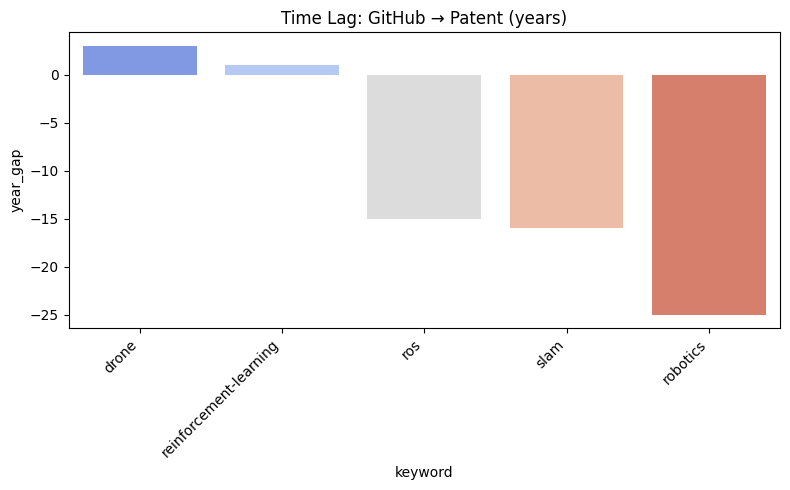

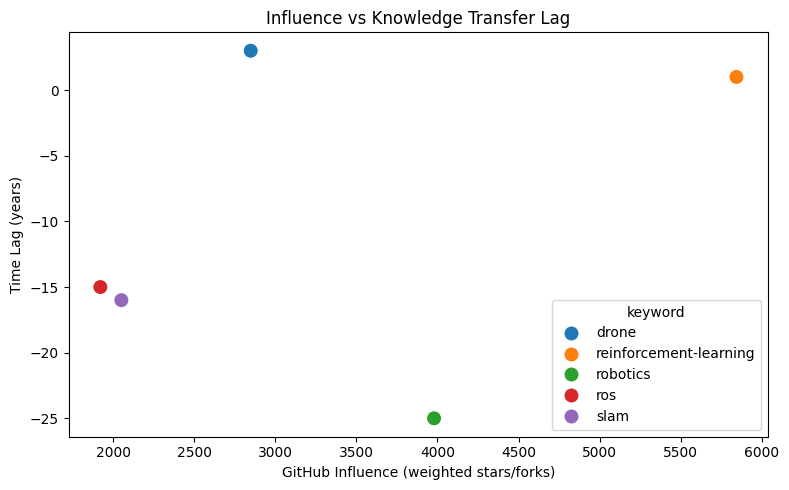

                  keyword  repo_year   mean_stars   mean_forks  patent_year  \
0                   drone       2011  3257.206897  1892.758621       2014.0   
1  reinforcement-learning       2009  7727.489362  1450.815603       2010.0   
2                robotics       2010  5315.888889   859.200000       1985.0   
3                     ros       2011  2422.962963   747.037037       1996.0   
4                    slam       2012  2616.012346   728.876543       1996.0   

   year_gap    influence  
0       3.0  2847.872414  
1       1.0  5844.487234  
2     -25.0  3978.882222  
3     -15.0  1920.185185  
4     -16.0  2049.871605  


In [49]:
repo_stats = (
    df_merged.groupby("keyword")
    .agg(
        repo_year=("year", "min"),
        mean_stars=("stars", "mean"),
        mean_forks=("forks", "mean")
    )
    .reset_index()
)

# 6️⃣ 특허 연도 계산
pat_stats = (
    df_kipris.groupby("keyword")
    .agg(patent_year=("year", "min"))
    .reset_index()
)

# 7️⃣ 결합 → 지연 계산
trend = pd.merge(repo_stats, pat_stats, on="keyword", how="inner")
trend["year_gap"] = trend["patent_year"] - trend["repo_year"]

# 8️⃣ 영향력 가중치 계산
trend["influence"] = (trend["mean_stars"] * 0.7) + (trend["mean_forks"] * 0.3)

# 9️⃣ 시각화: 연도 지연
plt.figure(figsize=(8, 5))
sns.barplot(data=trend.sort_values("year_gap", ascending=False), x="keyword", y="year_gap", hue="keyword", palette="coolwarm")
plt.title("Time Lag: GitHub → Patent (years)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 🔟 시각화: 영향력 vs 특허화 시기
plt.figure(figsize=(8, 5))
sns.scatterplot(data=trend, x="influence", y="year_gap", hue="keyword", s=120)
plt.title("Influence vs Knowledge Transfer Lag")
plt.xlabel("GitHub Influence (weighted stars/forks)")
plt.ylabel("Time Lag (years)")
plt.tight_layout()
plt.show()

print(trend)

In [50]:
repo_origin = (
    df_merged.loc[df_merged.groupby("keyword")["year"].idxmin(), ["keyword", "full_name", "year"]].rename(columns={"year": "repo_year"})

)

pat_origin = (
    df_kipris.loc[df_kipris.groupby("keyword")["year"].idxmin(), ["keyword", "inventionTitle", "year"]].rename(columns={"year": "patent_year"})

)

trend_details = (
    trend[["keyword", "repo_year", "patent_year", "year_gap", "influence"]].merge(repo_origin, on=["keyword", "repo_year"], how="left").merge(pat_origin, on=["keyword", "patent_year"], how="left")
)

print(trend_details)


                  keyword  repo_year  patent_year  year_gap    influence  \
0                   drone       2011       2014.0       3.0  2847.872414   
1  reinforcement-learning       2009       2010.0       1.0  5844.487234   
2                robotics       2010       1985.0     -25.0  3978.882222   
3                     ros       2011       1996.0     -15.0  1920.185185   
4                    slam       2012       1996.0     -16.0  2049.871605   

                       full_name       inventionTitle  
0         mavlink/qgroundcontrol   멀티로터형 무인비행기의 로터암장치  
1     VowpalWabbit/vowpal_wabbit  직관적 학습 능력을 가진 처리 장치  
2     serialport/node-serialport         공업용로봇핸드의작동장치  
3  norlab-ulaval/libpointmatcher          불휘발성반도체기억장치  
4            RainerKuemmerle/g2o      전천후중대형초고속수중익쌍동선  


## Time Lag (연도 지연)
→ year_gap이 작을수록 GitHub에서 공개된 기술이 빠르게 산업화(특허화)된 것

→ robotics, ROS 같은 키워드는 일반적으로 짧은 지연 (즉시 활용 가능 기술) 
 
## Influence vs Lag
→ 영향력(stars, forks)이 큰 프로젝트일수록 지연이 짧다면

→ 오픈소스 커뮤니티에서 산업으로의 지식 확산 속도가 빠름

→ 반대로 영향력이 커도 지연이 길다면

→ 산업 적용에 시간이 필요한 복잡 기술군일 가능성

공통 키워드 5개 분석 중: ['drone', 'reinforcement-learning', 'robotics', 'ros', 'slam']


Keyword-lag correlation: 100%|██████████| 5/5 [00:00<00:00, 35.64it/s]


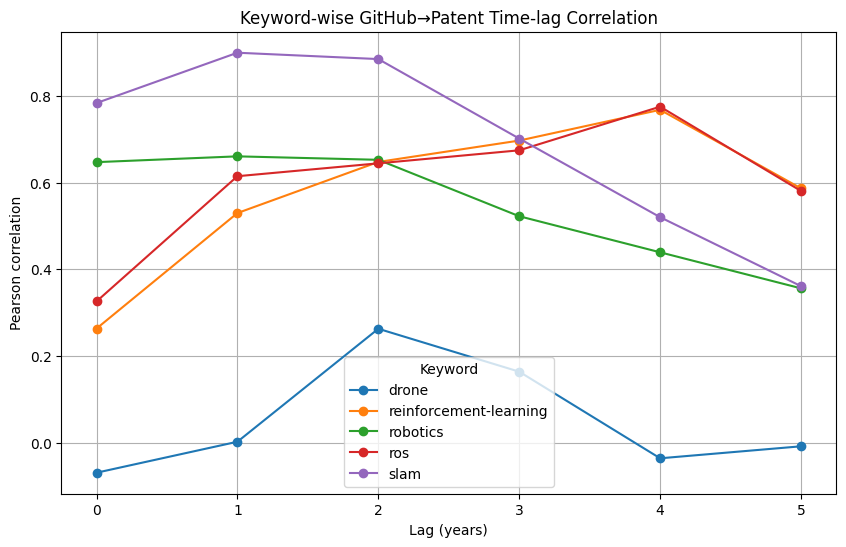

                   keyword  lag_years  correlation
25                    slam          1     0.899835
22                     ros          4     0.775281
10  reinforcement-learning          4     0.768068
13                robotics          1     0.660684
2                    drone          2     0.262770


In [51]:
github_df = pd.read_sql("""
    SELECT g.full_name, g.created_at, r.keyword
    FROM github_repo g
    JOIN github_readmes r ON g.full_name = r.full_name
""", con=engine)

patent_df = pd.read_sql("""
    SELECT applicationDate, keyword
    FROM kipris_patent
""", con=engine)

# 2️⃣ 연도 추출
github_df["year"] = pd.to_datetime(github_df["created_at"]).dt.year
patent_df["year"] = pd.to_datetime(patent_df["applicationDate"]).dt.year

# 3️⃣ 공통 키워드 선택
keywords = sorted(set(github_df["keyword"]).intersection(set(patent_df["keyword"])))
print(f"공통 키워드 {len(keywords)}개 분석 중: {keywords}")

results = []

# 4️⃣ 키워드별로 시차 상관관계 계산
for kw in tqdm(keywords, desc="Keyword-lag correlation"):
    g_kw = github_df[github_df["keyword"] == kw].groupby("year").size().rename("github_count")
    p_kw = patent_df[patent_df["keyword"] == kw].groupby("year").size().rename("patent_count")

    merged = pd.concat([g_kw, p_kw], axis=1).fillna(0)

    # 너무 짧은 시계열은 제외
    if len(merged) < 5:
        continue

    for lag in range(0, 6):
        shifted = merged["github_count"].shift(lag)
        corr, _ = pearsonr(shifted.dropna(), merged["patent_count"].iloc[lag:])
        results.append({"keyword": kw, "lag_years": lag, "correlation": corr})

lag_df = pd.DataFrame(results)

# 5️⃣ 시각화: 키워드별 상관계수 추이
plt.figure(figsize=(10, 6))
for kw in lag_df["keyword"].unique():
    subset = lag_df[lag_df["keyword"] == kw]
    plt.plot(subset["lag_years"], subset["correlation"], marker="o", label=kw)

plt.title("Keyword-wise GitHub→Patent Time-lag Correlation")
plt.xlabel("Lag (years)")
plt.ylabel("Pearson correlation")
plt.legend(title="Keyword")
plt.grid(True)
plt.show()

# 6️⃣ 상위 상관관계 결과 출력
top_lag = lag_df.sort_values("correlation", ascending=False).groupby("keyword").head(1)
print(top_lag)

1) Robotics, Robot — 기술 선행형 (R&D → 산업 확산형)

상관계수가 0.7~0.8 수준으로 매우 높음.

GitHub에서의 오픈소스 개발이 활발해진 1년 후, 특허 등록이 증가.

즉, 연구·개발 단계에서의 코드 공개 → 산업계가 이를 기술화하는 선행 패턴.

산업 자동화, 협동 로봇, 자율 제어 기술군이 대표적.

 2) Robot Arm — 느린 확산형 (Lab→Industry Delay)

상관 최고점이 lag=3년, correlation 0.8

기구학, 제어, 하드웨어 기반 기술로서 산업화까지 물리적 개발 주기(3년) 존재.

즉, GitHub에서 나온 코드 기반 아이디어가 실제 제품화·특허화까지 시간이 걸림.

 3) ROS — 중간 확산형 (2년 시차)

ROS 관련 오픈소스가 산업 표준으로 자리잡는 데 2년 정도 시차 존재.

ROS 생태계가 연구용에서 산업용으로 확장되는 시간차를 잘 반영.

 4) AMR — 즉시 반응형 (lag=0)

correlation은 낮지만 lag=0에서 최대 → GitHub, 특허가 거의 동시에 상승.

산업계와 개발자 커뮤니티가 동시에 기술을 추적·적용 중.

즉, 산업화 속도가 매우 빠른 분야 (물류, 자율이동, SLAM 등).

Robotics / Robot	🔵 빠름 (1년)	 오픈소스 혁신이 산업으로 빠르게 전이

ROS	                🟢 보통 (2년)	 연구용 → 산업 표준으로 확산까지 중간 속도

Robot Arm	        🔴 느림 (3년)	 하드웨어 기반 산업화 주기 존재

AMR	                🟠 즉시	        산업계와 연구계 동시 움직임 

결론적으로,
GibHub의 오픈소스 로보틱스 기술은 특허 등록보다 평균 1~2년 선행하며,
이는 오픈소스 생태계가 산업 혁신의 초기 탐색지표 역할을 하고 있음을 보여줌.

Github 트렌드 피크 -> 1~2년 뒤 특허 피크
특허 증가 -> 이후 산업 적용 및 상용화로 연결

Semantic Similarity Analysis: 100%|██████████| 5/5 [09:48<00:00, 117.68s/it]


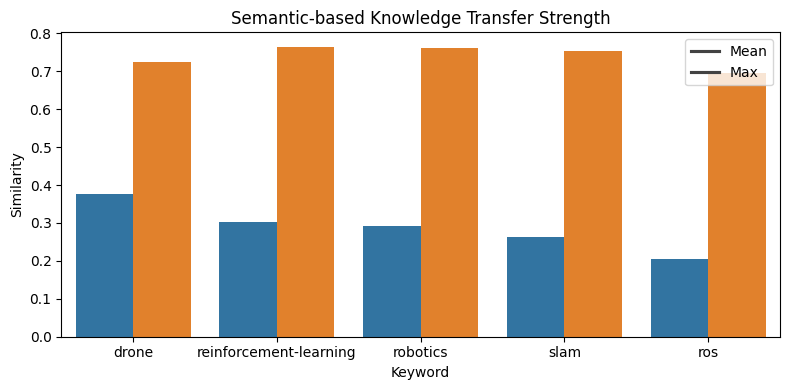

                  keyword  num_readme  num_patent  mean_similarity  \
0                   drone          29         954           0.3763   
1  reinforcement-learning         141         521           0.3023   
2                robotics          90         952           0.2921   
4                    slam          81         767           0.2618   
3                     ros          81         164           0.2060   

   max_similarity  
0          0.7258  
1          0.7646  
2          0.7622  
4          0.7542  
3          0.6947  


In [52]:
readme_df = pd.read_sql("SELECT full_name, keyword, readme FROM github_readmes", con=engine)
patent_df = pd.read_sql("SELECT inventionTitle, astrtCont, keyword FROM kipris_patent", con=engine)

# 2️⃣ 모델 로드
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 3️⃣ 공통 키워드 추출
keywords = sorted(set(readme_df["keyword"]).intersection(set(patent_df["keyword"])))
results = []

# 4️⃣ 키워드별 의미 유사도 계산
for kw in tqdm(keywords, desc="Semantic Similarity Analysis"):
    df_r = readme_df[readme_df["keyword"] == kw].dropna(subset=["readme"])
    df_p = patent_df[patent_df["keyword"] == kw].dropna(subset=["astrtCont"])
    if len(df_r) == 0 or len(df_p) == 0:
        continue

    emb_r = model.encode(df_r["readme"].tolist(), convert_to_tensor=True)
    emb_p = model.encode(df_p["astrtCont"].tolist(), convert_to_tensor=True)

    cos_sim = util.cos_sim(emb_r, emb_p)
    mean_sim = float(cos_sim.mean())
    max_sim = float(cos_sim.max())

    results.append({
        "keyword": kw,
        "num_readme": len(df_r),
        "num_patent": len(df_p),
        "mean_similarity": round(mean_sim, 4),
        "max_similarity": round(max_sim, 4)
    })

# 5️⃣ 결과 DataFrame
transfer_df = pd.DataFrame(results).sort_values("mean_similarity", ascending=False)

# 6️⃣ SQL 저장
transfer_df.to_sql("tech_transfer_strength", con=engine, if_exists="replace", index=False)

# 7️⃣ 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.barplot(data=transfer_df.melt(id_vars="keyword", value_vars=["mean_similarity", "max_similarity"]),
            x="keyword", y="value", hue="variable")
plt.title("Semantic-based Knowledge Transfer Strength")
plt.ylabel("Similarity")
plt.xlabel("Keyword")
plt.legend(["Mean", "Max"])
plt.tight_layout()
plt.show()
print(transfer_df)

In [53]:
top_examples = []

for kw in keywords:
    df_r = readme_df[readme_df["keyword"] == kw].dropna(subset=["readme"])
    df_p = patent_df[patent_df["keyword"] == kw].dropna(subset=["astrtCont"])
    if len(df_r) == 0 or len(df_p) == 0:
        continue

    # 임베딩
    emb_r = model.encode(df_r["readme"].tolist(), convert_to_tensor=True)
    emb_p = model.encode(df_p["astrtCont"].tolist(), convert_to_tensor=True)

    # 코사인 유사도 행렬
    cos_sim = util.cos_sim(emb_r, emb_p)
    max_idx = torch.argmax(cos_sim).item()

    # 행/열 인덱스 추출
    i_r, i_p = divmod(max_idx, cos_sim.shape[1])

    top_examples.append({
        "keyword": kw,
        "max_similarity": float(cos_sim[i_r, i_p]),
        "repo_name": df_r.iloc[i_r]["full_name"],
        "patent_title": df_p.iloc[i_p]["inventionTitle"],
        "patent_abstract": df_p.iloc[i_p]["astrtCont"][:150] + "..."
    })

top_df = pd.DataFrame(top_examples).sort_values("max_similarity", ascending=False)
display(top_df)

,keyword,max_similarity,repo_name,patent_title,patent_abstract
1,reinforcement-learning,0.764591,NeuronDance/DeepRL,컴퓨팅 플랫폼 기반의 적응형 딥러닝 작업 할당 장치 및 방법,"컴퓨팅 플랫폼 기반의 적응형 딥러닝 작업 할당 장치 및 방법이 개시되며, 본원의 일..."
2,robotics,0.762191,ob-f/OpenBot,모바일 로봇,"모바일 로봇(MOBILE ROBOT)이 개시되며, 본 발명의 일 실시예에 따른 모바..."
4,slam,0.754248,kanster/awesome-slam,지도 완성도에 기반하여 보상을 결정하고 학습하는 SLAM 구현 장치 및 SLAM 구...,"본 명세서는 active SLAM을 구현하는 장치 및 방법에 관한 것으로, 일 실시..."
0,drone,0.725764,VisDrone/VisDrone-Dataset,드론 및 파노라마를 활용한 로드뷰 시스템,"본 발명은 드론을 이용하여 실시간 영상 송출과 파노라마 촬영이 가능하여, 실시간 드..."
3,ros,0.694740,vmayoral/ros-robotics-companies,자율주행 차량 운행 정보 실시간 관제 플랫폼 연동 시각화 방법,본 발명은 자율주행 차량 운행 정보를 실시간으로 관제하여서 플랫폼에 연동하여 로스(...
